In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt 
import kaggle
import warnings

pd.options.display.max_columns==100
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
#kaggle.api.dataset_download_files(dataset='majedalhulayel/traffic-index-in-saudi-arabia-and-middle-east',
#                                  path='csv_files',
#                                  unzip=True,
#                                  quiet=False)

In [4]:
df=pd.read_csv('csv_files/traffic_index.csv')

In [5]:
df

,City,Datetime,TrafficIndexLive,JamsCount,JamsDelay,JamsLength,TrafficIndexWeekAgo,TravelTimeHistoric,TravelTimeLive
0,Abudhabi,2023-07-07 08:01:30,6,4,15.6,0.7,13,59.611918,54.803617
1,Abudhabi,2023-07-07 09:01:30,7,7,20.5,1.7,8,60.221387,56.118629
2,Abudhabi,2023-07-07 10:46:30,7,8,25.0,2.8,6,59.161978,55.518834
3,Abudhabi,2023-07-07 11:16:30,8,11,30.6,5.5,6,59.738138,56.413917
4,Abudhabi,2023-07-07 12:01:30,8,20,62.1,6.5,5,58.958314,56.059246
...,...,...,...,...,...,...,...,...,...
66634,Riyadh,2023-12-15 03:01:30,8,33,127.8,20.4,8,63.926569,63.245473
66635,Riyadh,2023-12-15 04:31:30,6,27,87.0,13.8,5,59.182641,60.012955
66636,Riyadh,2023-12-15 05:01:30,3,17,49.8,6.7,1,57.746816,57.561438
66637,Riyadh,2023-12-15 06:01:30,0,16,61.3,4.3,0,56.535277,55.463218


In [6]:
df['Datetime']=pd.to_datetime(df['Datetime'])

In [7]:
g=df.groupby(['City',
            df['Datetime'].dt.to_period('H')])['TrafficIndexLive'].mean().reset_index()
g=g.set_index(keys='Datetime')

In [8]:
g=g[g['City']=='Abudhabi'][['TrafficIndexLive']]

In [9]:
g

,TrafficIndexLive
Datetime,
2023-07-07 08:00,6.0
2023-07-07 09:00,7.0
2023-07-07 10:00,7.0
2023-07-07 11:00,8.0
2023-07-07 12:00,8.0
...,...
2023-12-15 03:00,1.0
2023-12-15 04:00,4.0
2023-12-15 05:00,4.0


new_hours = pd.date_range('2023-12-15 07:00', periods=24, freq='H')
formatted_new_hours = new_hours.strftime('%Y-%m-%d %H:%M')

g=g.dropna(how='all')
g = g.reindex(g.index.union(new_hours))
g.loc[new_hours] = 0
g

In [10]:
def df_to_Xy(df,lag):
    df_as_np=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-lag):
        row=[[r] for r in df_as_np[i:i+lag]]
        label=df_as_np[i+lag,df.columns.get_loc('TrafficIndexLive')]
        X.append(row),y.append(label)
    return np.array(X),np.array(y)  

In [11]:
X,y=df_to_Xy(g,48)

In [12]:
X.shape,y.shape

((3816, 48, 1, 1), (3816,))

In [13]:
train_idx=int(len(X)*0.8)
val_idx=int(len(X)*0.9)

X_train,y_train=X[:train_idx] ,y[:train_idx]
X_val,y_val=X[train_idx:val_idx], y[train_idx:val_idx]
X_test,y_test=X[val_idx:], y[val_idx:]

X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val=X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3052, 48, 1), (3052,), (382, 48, 1), (382,), (382, 48, 1), (382,))

### Building LSTM Model


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [15]:
model = Sequential()
model.add(InputLayer(input_shape=(48, 1)))  # Adjust the input shape
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


48/48 [==============================] - 4s 35ms/step - loss: 101.7336 - mae: 7.6657 - val_loss: 76.5864 - val_mae: 6.7632
Epoch 2/50
48/48 [==============================] - 1s 21ms/step - loss: 45.8973 - mae: 4.9591 - val_loss: 48.4666 - val_mae: 5.4610
Epoch 3/50
48/48 [==============================] - 1s 23ms/step - loss: 34.4316 - mae: 4.2348 - val_loss: 35.6971 - val_mae: 4.5502
Epoch 4/50
48/48 [==============================] - 1s 20ms/step - loss: 25.4910 - mae: 3.5216 - val_loss: 25.5380 - val_mae: 3.8097
Epoch 5/50
48/48 [==============================] - 1s 23ms/step - loss: 19.2492 - mae: 2.9852 - val_loss: 19.6108 - val_mae: 3.2768
Epoch 6/50
48/48 [==============================] - 1s 23ms/step - loss: 15.5307 - mae: 2.5987 - val_loss: 15.7025 - val_mae: 2.9323
Epoch 7/50
48/48 [==============================] - 1s 29ms/step - loss: 13.6227 - mae: 2.3359 - val_loss: 14.0867 - val_mae: 2.7060
Epoch 8/50
48/48 [==============================] - 2s 37ms/step -

In [18]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

12/12 [==============================] - 0s 7ms/step - loss: 10.2045 - mae: 2.0936
Test Loss: 10.204472541809082, Test MAE: 2.0935587882995605


from tensorflow.keras.models import load_model
model=load_model('model1/')

In [19]:
from sklearn import metrics

In [20]:
test_prediction=model.predict(X_test).flatten()
test_results=pd.DataFrame(data={'test Prediction':test_prediction,'Actual Values':y_test.flatten()})

12/12 [==============================] - 0s 6ms/step


0.7896505626687527


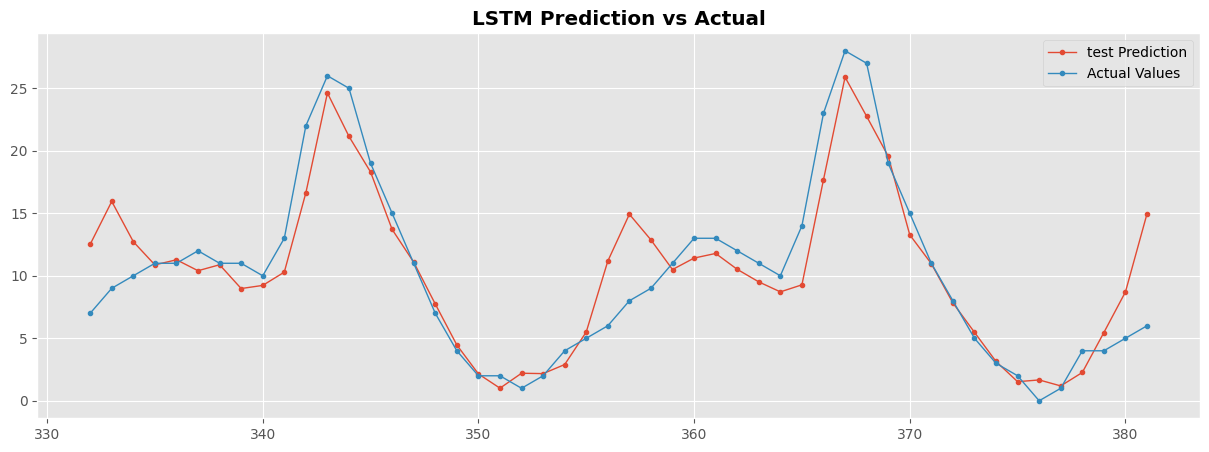

In [21]:
test_results[-50:].plot(lw=1,figsize=(15,5),marker='.')
plt.title('LSTM Prediction vs Actual',fontweight='bold')

print(metrics.r2_score(test_prediction,y_test))

In [22]:
import numpy as np

# Initialize an empty array to store the predicted values
predicted_values = []

# Use the last sequence from X_test as the initial input
current_input = X_test[-1]

# Define the number of steps to forecast (24 hours)
forecast_steps = 24

for i in range(forecast_steps):
    # Reshape the current input to match the model's input shape
    current_input_reshaped = current_input.reshape(1, current_input.shape[0], current_input.shape[1])
    
    # Use the model to predict the next value
    next_prediction = model.predict(current_input_reshaped)
    
    # Append the prediction to the list of predicted values
    predicted_values.append(next_prediction[0, 0])  # Assuming a single-output model
    
    # Prepare the next input for the next prediction
    next_input = np.append(current_input[1:], next_prediction, axis=0)
    
    # Update the current input for the next iteration
    current_input = next_input

# 'predicted_values' will contain the forecasted values for the next 24 hours
print(predicted_values)


1/1 [==============================] - 0s 24ms/step
[14.957934, 18.701218, 12.78773, 9.899718, 9.983293, 10.840937, 11.065406, 10.737984, 10.413161, 13.787182, 16.970129, 17.606884, 15.22303, 11.83721, 8.6013975, 5.912345, 4.0641193, 2.6439993, 1.8759853, 2.2925928, 3.4893212, 4.5896716, 6.206117, 10.503936]


In [23]:
for i,value in enumerate(predicted_values,start=1):
    test_results.loc[test_results.index[-1]+1]=[value,None]

0.7896505626687527


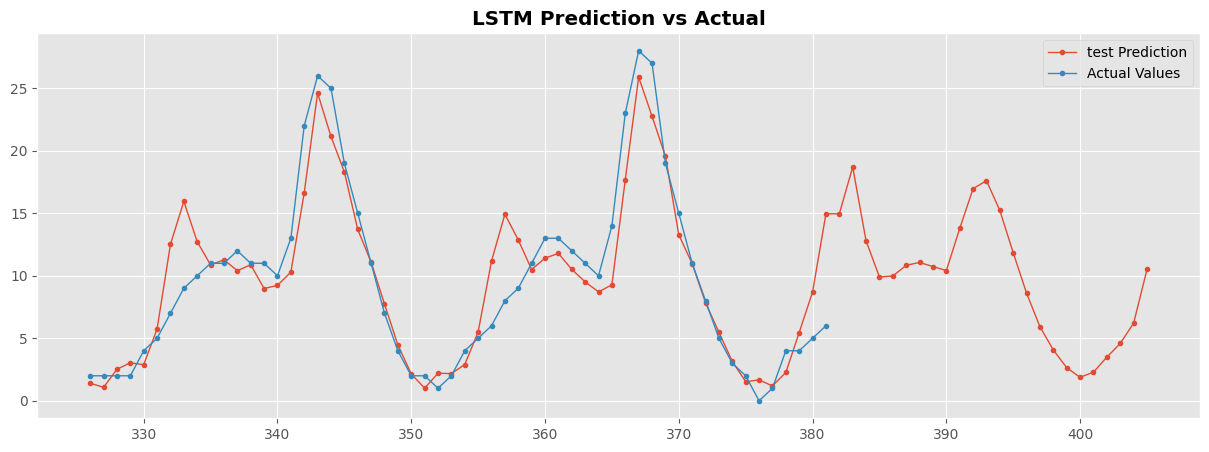

In [26]:
test_results[-80:].plot(lw=1,figsize=(15,5),marker='.')
plt.title('LSTM Prediction vs Actual',fontweight='bold')

print(metrics.r2_score(test_prediction,y_test))